# Simulating Circuits

* **Christopher J. Wood**
* Research Staff Member, Quantum Software Group
* IBM Thomas J. Watson Research Center, Yorktown Heights, NY
* *April 22, 2020*

![Circuit Simulation](figures/circuit_spectrum.png)

![Circuit Simulation](figures/circuit_purist.png)

# Simulating Circuits

We will demonstrate multiple ways to simulate circuits in Qiskit.

The right tool for the job depends on what information we wish to obtain...

# What do we want to simulate?

Generally there are three things we might want from a circuit simulation

1. **Counts:** measurement outcomes from an experiment
2. **Quantum State:** the output state of the circuit acting on an intial state
3. **Quantum Operator:** a representation of the circuit itself as an operator

Case 1 is a typical simulation for which you can use a HPC provider such as [Qiskit Aer](https://github.com/Qiskit/qiskit-aer).

For the other two cases we want to work with objects that represent a *quantum state* or *quantum operator* directly.

### Example Circuit

Lets start with a simple example circuit that would prepare a an N-qubit entangled GHZ state from the initial $|0^{\otimes n}\rangle$ state:
$$U_{GHZ}(n)|0^{\otimes n}\rangle = \frac{|0^{\otimes n}\rangle + |1^{\otimes n}\rangle}{\sqrt{2}}$$

We can write a simple function to generate the circuit for  $U_{GHZ}(n)$:

In [1]:
import qiskit
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

import numpy as np

def ghz_circuit(num_qubits):
    """Return an N-qubit GHZ preparation circuit."""
    circ = QuantumCircuit(num_qubits)
    circ.h(0)
    for j in range(1, num_qubits):
        circ.cx(0, j)
    return circ

In [2]:
ghz_circuit(2).draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [3]:
ghz_circuit(5).draw()

┌───┐                    
q_0: ┤ H ├──■────■────■────■──
     └───┘┌─┴─┐  │    │    │  
q_1: ─────┤ X ├──┼────┼────┼──
          └───┘┌─┴─┐  │    │  
q_2: ──────────┤ X ├──┼────┼──
               └───┘┌─┴─┐  │  
q_3: ───────────────┤ X ├──┼──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘

# Qiskit `quantum_info` module

* The `qiskit.quantum_info` module contains classes and functions for working with *quantum states* and *quantum operators*.
* In particular it can be used to simulate:
  * The output *quantum state* of quantum circuits.
  * The *quanutm operator* corresponding to a quantum circuit.

* Also contains tools for:
  * Manipulating states and operators
    * *compose, tensor etc*
  * Computing measures of states and operators
    * *state fidelity, average gate fidelity, diamond norm etc*
  * Generating random states and operators
  * Domposing quantum operators into quantum circuits
* See the [API documenation](https://qiskit.org/documentation/apidoc/quantum_info.html) for additional information!

# Statevector Class

* Lets start with the [Statevector](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html) class.

* In general this class represents a  general statevector on N-qudits (each subsystem can have a custom dimension).

* For now we will only consider the N-qubit case since our `QuantumCircuits` act on N-qubits.

## Simulating the output state of a circuit

* A `Statevector` can be constructed from `QuanutmCircuit` that contains only untiary gate instructions.
  * use `Statevector.from_instruction` class method
* This will construct the state returned from applying the circuit to the $|0^{\otimes n}\rangle$ state.
* An $N$-qubit circuit returns a `Statevector` containing a length-$2^N$ complex vector

### Example: 3-qubit GHZ (Bell) state circuit

In [4]:
qi.Statevector.from_instruction(ghz_circuit(3))

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))

### Accessing the Numpy array

If you want the underlying Numpy array you can get it using the `.data` attribute

In [5]:
state = qi.Statevector.from_instruction(ghz_circuit(3))
state.data

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

### Applying circuit to a different initial state

* A `Statevector` can also be initialized from an array into an arbitrary state
* Applying a circuit to an arbitrary state is done using `evolve` method

In [6]:
state = qi.Statevector(np.array([1, 0, 0, 0, 0, 0, 0, 1]) / np.sqrt(2))
state

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))

In [7]:
state.evolve(ghz_circuit(3))

Statevector([ 0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
              0.5+0.j,  0.5+0.j],
            dims=(2, 2, 2))

### We can also initialize from computational basis state

* This uses the `from_label` class method

In [8]:
state = np.sqrt(0.5) * (
        qi.Statevector.from_label('000')
        + qi.Statevector.from_label('111'))
state

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))

## Applying circuit or gates iteratively

* One use for `Statevector` class is to monitor the state as you apply a sequence of gates or circuits

### Example: apply GHZ circuit then inverse

In [9]:
state0 = qi.Statevector.from_label('000')
print('Step 0:\n', state0)

state1 = state0.evolve(ghz_circuit(3))
print('Step 1:\n', state1)

state2 = state1.evolve(ghz_circuit(3).inverse())
print('Step 2:\n', state2)

Step 0:
 Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Step 1:
 Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Step 2:
 Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


### Example: applying GHZ circuit one gate at a time

* Now we demonstate how to apply qiskit `Gate` objects one at a time to track the evolution of a state

In [10]:
from qiskit.extensions import HGate, CXGate

H = HGate()
CX = CXGate()

state0 = qi.Statevector.from_label('000')
print('Step 0:\n', state0)

state1 = state0.evolve(H, [0])
print('Step 1:\n', state1)

state2 = state1.evolve(CX, [0, 1])
print('Step 2:\n', state2)

state3 = state2.evolve(CX, [0, 2])
print('Step 3:\n', state3)

Step 0:
 Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Step 1:
 Statevector([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))
Step 2:
 Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))
Step 3:
 Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


### Additional Information

*  `Statevector` objects also have methods to compose, add, subtract, multiply, and tensor product them together. 
* We won't cover them here but see [Operator API documentation](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html) for more details.

# DensityMatrix Class

* There is also a [DensityMatrix](https://qiskit.org/documentation/stubs/qiskit.quantum_info.DensityMatrix.html) class.

* It has the same basic functionality as `Statevector` but stores a density matrix instead.

* We'll come back to this more later!

In [11]:
qi.DensityMatrix.from_instruction(ghz_circuit(2))

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))

# Operator Class

* Next lets move to constructing the operator representation of the circuit itself, starting with the [Operator](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) class.

* The [Operator](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) class represents a general complex matrix on N-qudits (each subsystem can have a custom dimension).

* For now we will only consider the N-qubit case since our `QuantumCircuits` act on N-qubits.

## Simulating a circuit with an `Operator`

* An `Operator` can be initialized from a `QuantumCircuit` if it has no classical instructions.
* This will construct the unitary `Operator` for that circuit
* A $N$-qubit circuit returns a $2^N \times 2^N$ dimensional complex array `Operator`

### Example 2-qubit GHZ (Bell) state circuit

In [12]:
unitary = qi.Operator(ghz_circuit(2))
print(unitary)

Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
           -0.70710678+0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
            0.70710678+0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
            0.        +0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


### Accessing the Numpy array

* If you want the underlying Numpy array you can get it using the `.data` attribute

In [13]:
unitary.data

array([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
        -0.70710678+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
         0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
         0.        +0.j]])

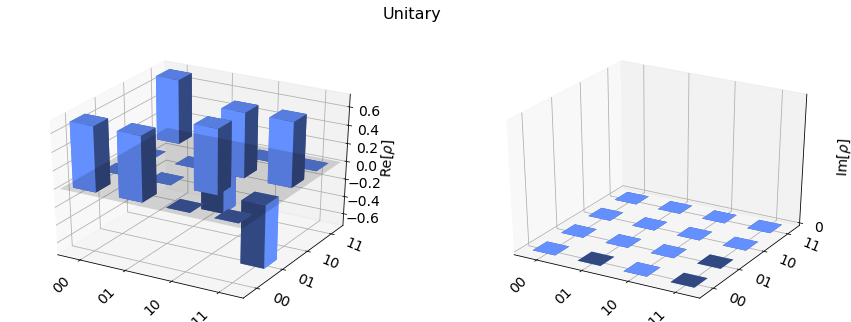

In [14]:
from qiskit.visualization import plot_state_city

plot_state_city(unitary.data, title='Unitary')

### Applying circuit to a different initial unitary

* We can also compose a quantum circuit with an `Operator` in an arbitrary initial state.
* Applying a circuit to an arbitrary operator is done using `compose` method
* We can initialize an `Operator` in single-qubit tensor product state using the `from_label` method

In [15]:
unitary = qi.Operator.from_label('XX')
print(unitary)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [16]:
unitary.compose(ghz_circuit(2))

Operator([[ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
            0.70710678+0.j],
          [-0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
            0.70710678+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

### Example: applying GHZ circuit gates one at a time

* Now we demonstate how to apply qiskit `Gate` objects one at a time to track the value of a circuit

In [17]:
from qiskit.extensions import HGate, CXGate

H = HGate()
CX = CXGate()

unitary0 = qi.Operator.from_label('II')
print('Step 0:\n', unitary0)

unitary1 = unitary0.compose(H, [0])
print('Step 1:\n', unitary1)

unitary2 = unitary1.compose(CX, [0, 1])
print('Step 2:\n', unitary2)


Step 0:
 Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Step 1:
 Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
            0.70710678+0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
           -0.70710678+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Step 2:
 Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
           -0.70710678+0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
            0.70710678+0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,


### Additional Information
*  `Operators` also have methods to compose, add, subtract, multiply, and tensor product them together. 
* We won't cover them here but see [Operator API documentation](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) for more details.

# Clifford Class

* Next we consider a different type of operator that is *classically efficient* to simulate
* Clifford circuits are circuits that can be decomposed into X, Y, Z, H, S, CX, CY, CZ, SWAP gates
* A minimal set is H, S, CX(https://qiskit.org/documentation/stubs/qiskit.quantum_info.Clifford.html).
* We will now demonstate the [Clifford](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Clifford.html) class

## Simulating a circuit with a `Clifford`

* Like with an `Operator`, a `Clifford` can be initialized from a `QuantumCircuit` if it only contains Clifford gates, and no classical instructions
* This will construct the `Clifford` operator for that circuit
* A $N$-qubit circuit is returns a $2N \times 2N$ boolean array and $2N$ boolean vector for a  `Clifford`

### Example 2-qubit GHZ (Bell) state circuit

In [18]:
cliff = qi.Clifford(ghz_circuit(2))
cliff

Clifford(StabilizerTable(
array([[False, False,  True, False],
       [False,  True, False, False],
       [ True,  True, False, False],
       [False, False,  True,  True]]),
phase=array([False, False, False, False])))

## Clifford representation

* Internally the Clifford is represnted as a [StabilizerTable](https://qiskit.org/documentation/stubs/qiskit.quantum_info.StabilizerTable.html) object.
* This contains:
  * A shape (2N,2N) boolean array (sympletic Pauli table)
  * A shape (2N,) boolean vector (phase vector)
* These can be accessed as follows:

In [19]:
cliff.table

StabilizerTable(
array([[False, False,  True, False],
       [False,  True, False, False],
       [ True,  True, False, False],
       [False, False,  True,  True]]),
phase=array([False, False, False, False]))

In [20]:
cliff.table.array

array([[False, False,  True, False],
       [False,  True, False, False],
       [ True,  True, False, False],
       [False, False,  True,  True]])

In [21]:
cliff.table.phase

array([False, False, False, False])

## Human readible Clifford representation

* There is also a more human readable dictionary representaiton for a `Clifford`
* You can use the `Clifford.to_dict` and `Clifford.from_dict` methods to convert
* The dict representation is displayed when you `print` a Clifford object

In [22]:
cliff.to_dict()

{'stabilizer': ['+XX', '+ZZ'], 'destabilizer': ['+IZ', '+XI']}

In [23]:
print(cliff)

Clifford: Stabilizer = ['+XX', '+ZZ'], Destabilizer = ['+IZ', '+XI']


## Applying circuit or gates iteratively

* As with `Operator` we can use the `compose` method of `Clifford` objects to compose quantum circuits, gates, or other clifford iteratively

In [24]:
from qiskit.extensions import HGate, CXGate

H = HGate()
CX = CXGate()

nq = 4
cliff0 = qi.Clifford(np.eye(2 * nq))
print('Step 0:\n', cliff0)

cliff1 = cliff0.compose(H, [0])
print('Step 1:\n', cliff1)

cliff2 = cliff1.compose(CX, [0, 1])
print('Step 2:\n', cliff2)

cliff3 = cliff2.compose(CX, [0, 2])
print('Step 3:\n', cliff3)

cliff4 = cliff3.compose(CX, [0, 3])
print('Step 4:\n', cliff4)

Step 0:
 Clifford: Stabilizer = ['+IIIZ', '+IIZI', '+IZII', '+ZIII'], Destabilizer = ['+IIIX', '+IIXI', '+IXII', '+XIII']
Step 1:
 Clifford: Stabilizer = ['+IIIX', '+IIZI', '+IZII', '+ZIII'], Destabilizer = ['+IIIZ', '+IIXI', '+IXII', '+XIII']
Step 2:
 Clifford: Stabilizer = ['+IIXX', '+IIZZ', '+IZII', '+ZIII'], Destabilizer = ['+IIIZ', '+IIXI', '+IXII', '+XIII']
Step 3:
 Clifford: Stabilizer = ['+IXXX', '+IIZZ', '+IZIZ', '+ZIII'], Destabilizer = ['+IIIZ', '+IIXI', '+IXII', '+XIII']
Step 4:
 Clifford: Stabilizer = ['+XXXX', '+IIZZ', '+IZIZ', '+ZIIZ'], Destabilizer = ['+IIIZ', '+IIXI', '+IXII', '+XIII']


### Efficient Simulation with Clifford

* We stated that Clifford simulation is efficient.
* Lets demonstrate with our GHZ exmaple simulating from 10 to 5000 qubits.
* We see that the simulation of a `QuantumCircuit` is actually faster than constructing the `QuantumCircuit`!

![Clifford Simulation](benchmarks/t_sim_clifford.png)

### Additional Information
*  `Clifford` operators also have methods to compose and tensor product them together. 
* See the [Clifford API documentation](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Clifford.html) for more details.

# SuperOp Class

* If we want to include non-unitary quantum instructions in our circuit (such as noise) we can no longer use the `Operator` class.
* Our circuit is no-longer unitary. It is a generalization called a `QuantumChannel`.
* We can use several different classes to represent `QuantumChannels`:
  * [SuperOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SuperOp.html)
  * [Kraus](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Kraus.html)
  * [Choi](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Choi.html)
  * [Stinespring](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Stinespring.html)
  * [PTM](https://qiskit.org/documentation/stubs/qiskit.quantum_info.PTM.html)
  * [Chi](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Chi.html)
* We will focus on the `SuperOp` class here as it is what is used for simulation of noisy circuits.

## Simulating a circuit with a `SuperOp`

* An `SuperOp` can be initimalized from a `QuantumCircuit` if it has no classical instructions.
* Circuit can also include reset instructions
* This will construct the Quantum channel `SuperOp` for that circuit
* A $N$-qubit circuit returns a $4^N \times 4^N$ dimensional complex array for a `SuperOp`

### Example 2-qubit GHZ (Bell) state circuit

In [25]:
sop = qi.SuperOp(ghz_circuit(2))
sop

SuperOp([[ 0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,
           0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
           0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
         [ 0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,
           0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
           0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
         [ 0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,
           0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
           0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
         [ 0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j,
           0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
           0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
         [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
           0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,
          -0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
         [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +

### Accessing the Numpy array

* Like `Operator`, if you want the underlying Numpy array you can get it using the `.data` attribute

In [26]:
sop.data

array([[ 0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,
         0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,
         0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,
        -0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
       

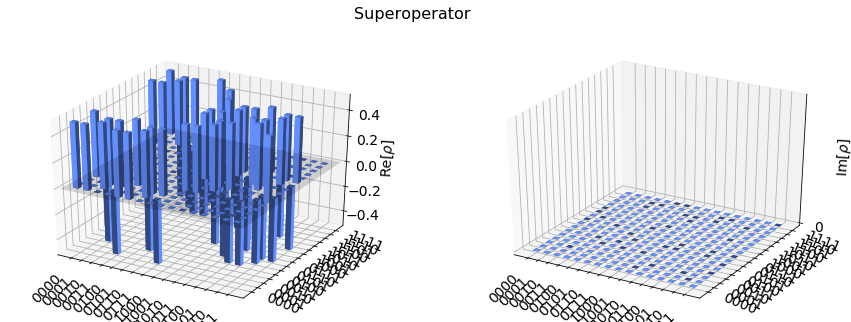

In [27]:
plot_state_city(sop.data, title='Superoperator')

### Converting to another Quantum Channel representation

* If you want to use a different representation (ie `Kraus` or `PTM`) you can convert between them easily.

#### Example: convert `SuperOp` to `Kraus`

In [28]:
qi.Kraus(sop)

Kraus([[[-0.70710678-0.j, -0.70710678+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
          0.70710678+0.j],
        [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
         -0.70710678-0.j],
        [-0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
          0.        +0.j]]],
      input_dims=(2, 2), output_dims=(2, 2))

* You can also go straing from a `QuantumCircuit` to another quantum channel
* Behind the scense this still does simulation as a `SuperOp` and then converts the output for you

In [29]:
qi.Kraus(ghz_circuit(2))

Kraus([[[-0.70710678-0.j, -0.70710678+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
          0.70710678+0.j],
        [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
         -0.70710678-0.j],
        [-0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
          0.        +0.j]]],
      input_dims=(2, 2), output_dims=(2, 2))

### Converting to an Operator

* You can also convert a QuantumChannel to an operator **if** it is a unitary.
* Note this is expensive (involves a eigen-decomposition)
* If you know input is unitary, better to use `Operator` directly

In [30]:
qi.Operator(sop)

Operator([[-0.70710678-0.j, -0.70710678+0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
            0.70710678+0.j],
          [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
           -0.70710678-0.j],
          [-0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
            0.        +0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

### Additional Information
*  `SuperOp` also have methods to compose, add, subtract, multiply, and tensor product them together.
* They can be converted into other representations (ie `Kraus`, `PTM` etc) easily.
* We won't cover them here but see [SuperOp API documentation](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SuperOp.html) for more details.
* For more information about Quantum channel representations used in Qiskit see review paper: 
*CJ Wood, JD Biamonte, DG. Cory, Tensor networks and graphical calculus for open quantum systems* [arXiv:1111.6950 (quant-ph)](https://arxiv.org/abs/1111.6950)

# Simulation Cost

* `Statevector`, `DensityMatrix`, `Clifford`, `Operator`, `SuperOp` all have different scaling

| Class |  Allowed Circuit Types |Simulation Time | Simulation Memory |
| --- | --- | --- | --- |
| [Clifford](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Clifford.html) | Clifford circuits | $O(N)$ | $O(N^2)$ |
| [Statevector](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html) | Unitary circuits | $O(2^N)$ | $O(2^N)$ |
| [Operator](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) | Unitary circuits | $O(4^{N})$ | $O(4^{N})$ |
| [DensityMatrix](https://qiskit.org/documentation/stubs/qiskit.quantum_info.DensityMatrix.html) | Quantum channel (non-unitary) circuits | $O(4^{N})$ | $O(4^{N})$ |
| [SuperOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SuperOp.html) | Quantum channel (non-unitary) circuits |$O(16^{N})$ | $O(16^{N})$ |

![Circuit Simulation](benchmarks/t_sim.png)

# Inserting Quantum Operators into Circuits

Now that we have shown how to simulate circuits with operators, we show how we can also use operators in circuits

## Inserting a random unitary into a circuit

We will use the [random_unitary](https://qiskit.org/documentation/stubs/qiskit.quantum_info.random_unitary.html) function to generate 1 and 2-qubit random unitary matrices and insert them into a `QuantumCircuit`.

* `random_unitary` returns a unitary `Operator` object
* An `Operator` can be added to a `QuantumCircuit` using the `append` method.

In [31]:
# Generate random unitary operator
u1q = qi.random_unitary(2)
u2q = qi.random_unitary(2 ** 2)

# Can be added to a circuit
circ = qiskit.QuantumCircuit(2)
circ.append(u1q, [0])
circ.append(u2q, [0, 1])
circ.draw()

┌─────────┐┌──────────┐
q_0: ┤ Unitary ├┤0         ├
     └─────────┘│  Unitary │
q_1: ───────────┤1         ├
                └──────────┘

### Transpiling to basis gates

We can transpile arbitrary unitaries into a basis gate that could be run on an actual device.

* Transpiling involves a *synthesis* algorithm to decompose an operator into gates
* *NOTE: currently this only works for 1 and 2-qubit `Operator`*

In [32]:
# Decompose into basis gates
circ_basis = qiskit.transpile(circ, basis_gates=['u3', 'cx'])
circ_basis.draw()

┌────────────────────────────┐     ┌───────────────────────┐      »
q_0: ┤ U3(1.9296,0.011267,2.9516) ├──■──┤ U3(0.82257,pi/2,pi/2) ├───■──»
     ├────────────────────────────┤┌─┴─┐├───────────────────────┴┐┌─┴─┐»
q_1: ┤ U3(1.4227,-1.7333,-2.3556) ├┤ X ├┤ U3(pi/2,-pi/1,0.22223) ├┤ X ├»
     └────────────────────────────┘└───┘└────────────────────────┘└───┘»
«     ┌─────────────────────┐     ┌──────────────────────────┐
«q_0: ┤ U3(0.18025,pi,pi/2) ├──■──┤ U3(1.2139,1.9972,4.1689) ├
«     └─┬──────────────────┬┘┌─┴─┐├──────────────────────────┤
«q_1: ──┤ U3(pi/2,0,3pi/2) ├─┤ X ├┤ U3(2.0582,3.9107,2.1014) ├
«       └──────────────────┘ └───┘└──────────────────────────┘

### Checking transpilation

We can then check the transpiled circuit is equivalent to the original circuit.

* We can do this using operator *measures* in `quantum_info`.
* We will use the [average_gate_fidelity](https://qiskit.org/documentation/stubs/qiskit.quantum_info.average_gate_fidelity.html) function for this

* *NOTE: transpiling might introduce a global phase*

In [33]:
# Can then still simulate back to an operator
op1 = qi.Operator(circ)
op2 = qi.Operator(circ_basis)
qi.average_gate_fidelity(op1, op2)

1.0000000000000004

## Inserting a random clifford into a circuit

* There is also a [random_clifford](https://qiskit.org/documentation/stubs/qiskit.quantum_info.random_clifford.html) function we can use to generate a random N-qubit `Clifford` object
* This can also be inserted into a circuit

In [34]:
# Generate a random clifford
rc = qi.random_clifford(2)

# Can be added to a circuit
circ = qiskit.QuantumCircuit(2)
circ.append(rc, [0, 1])
circ.draw()

┌───────────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                      ├
     │  Clifford: stabilizer = ['-ix', '-zi'], destabilizer = ['+iy', '+yi'] │
q_1: ┤1                                                                      ├
     └───────────────────────────────────────────────────────────────────────┘

### Clifford Synthesis

* To execute a Clifford it can be synthezed into Clifford gates
* In qiskit this synthesis is *optimal* in the number of CX gates in the decomposition for up to 3-qubits
  * Method based on *S. Bravyi and D. Maslov, Hadamard-free circuits expose the structure of the Clifford group*  [arXiv:2003.09412 [quant-ph]](https://arxiv.org/abs/2003.09412)
* Decomposition for N > 3 qubits still works but is not optimal

In [35]:
# Basis gates for Clifford circuit
clifford_gates = ['i', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'cx']

### Example: 3-qubit optimal Clifford synthesis

In [36]:
# Generate random clifford and add to circuit
nq = 3
rc = qi.random_clifford(nq)
circ = qiskit.QuantumCircuit(nq)
circ.append(rc, range(nq))
circ.draw()

# Decompose into basis gates
circ_basis = qiskit.transpile(circ, basis_gates=clifford_gates)
circ_basis.draw()

┌─────┐┌───┐     ┌───┐┌───┐     ┌─────┐┌───┐               
q_0: ┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├──■──┤ Sdg ├┤ H ├──■────────────
     └─────┘└───┘┌─┴─┐├───┤├───┤  │  └─────┘└───┘  │            
q_1: ────────────┤ X ├┤ H ├┤ S ├──┼────────────────┼────────────
      ┌───┐ ┌───┐└───┘└───┘└───┘┌─┴─┐┌─────┐┌───┐┌─┴─┐┌───┐┌───┐
q_2: ─┤ Y ├─┤ H ├───────────────┤ X ├┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├
      └───┘ └───┘               └───┘└─────┘└───┘└───┘└───┘└───┘

### Validation

We can check the synthesis is correct via Clifford simulation

In [37]:
rc == qi.Clifford(circ_basis)

True

### Example: 10-qubit sub-optimal Clifford synthesis

In [38]:
# Generate random clifford and add to circuit
nq = 10
rc = qi.random_clifford(nq)
circ = qiskit.QuantumCircuit(nq)
circ.append(rc, range(nq))
circ.draw()

# Decompose into basis gates
circ_basis = qiskit.transpile(circ, basis_gates=clifford_gates)
circ_basis.draw()

┌───┐ ┌───┐                                                           »
q_0: ┤ Z ├─┤ H ├───────────────────────────────────────────────────────────»
     ├───┤┌┴───┴┐                                                          »
q_1: ┤ H ├┤ Sdg ├──────────────────────────────────────────────────────────»
     ├───┤└┬───┬┘                                                          »
q_2: ┤ Z ├─┤ H ├───────────────────────────────────────────────────────────»
     ├───┤ ├───┤                                                           »
q_3: ┤ Z ├─┤ H ├───────────────────────────────────────────────────────────»
     ├───┤ ├───┤                                                           »
q_4: ┤ X ├─┤ H ├───────────────────────────────────────────────────────────»
     ├───┤ ├───┤ ┌─────┐                                                   »
q_5: ┤ Z ├─┤ H ├─┤ Sdg ├───────────────────────────────────────────────────»
     ├───┤ ├───┤ └─────┘                                                   »
q_6: ┤ Z ├─┤ H ├───────────────────────────────────────────────────────────»
     └───┘ └───┘                              ┌───┐┌───┐┌─────┐┌───┐┌─────┐»
q_7: ─────────────────────────────────────────┤ X ├┤ X ├┤ Sdg ├┤ X ├┤ Sdg ├»
     ┌───┐ ┌───┐ ┌─────┐┌───┐┌───┐┌─────┐┌───┐└─┬─┘└─┬─┘└─────┘└─┬─┘└─────┘»
q_8: ┤ X ├─┤ H ├─┤ Sdg ├┤ H ├┤ X ├┤ Sdg ├┤ X ├──┼────■───────────┼─────────»
     ├───┤┌┴───┴┐└─────┘└───┘└─┬─┘└─────┘└─┬─┘  │                │         »
q_9: ┤ X ├┤ Sdg ├──────────────■───────────■────■────────────────■─────────»
     └───┘└─────┘                                                          »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_1: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_2: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_3: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_4: ──────────────────────────────────────────────────────────────────■──»
«                                                           ┌───┐┌───┐  │  »
«q_5: ─────────────────────────────────────────■────■────■──┤ H ├┤ X ├──┼──»
«          ┌───┐┌───┐┌─────┐┌───┐┌─────┐       │    │    │  └───┘└─┬─┘  │  »
«q_6: ──■──┤ H ├┤ X ├┤ Sdg ├┤ X ├┤ Sdg ├──■────┼────┼────┼─────────┼────┼──»
«     ┌─┴─┐└───┘└─┬─┘└─────┘└─┬─┘└─────┘  │    │    │  ┌─┴─┐       │    │  »
«q_7: ┤ X ├───────■───────────■───────────┼────┼────┼──┤ X ├───────┼────┼──»
«     └───┘                               │    │  ┌─┴─┐└───┘       │  ┌─┴─┐»
«q_8: ────────────────────────────────────┼────┼──┤ X ├────────────■──┤ X ├»
«                                       ┌─┴─┐┌─┴─┐└───┘               └───┘»
«q_9: ──────────────────────────────────┤ X ├┤ X ├─────────────────────────»
«                                       └───┘└───┘                         »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_1: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_2: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_3: ─────────────────────────────────────────────────────────────────────»
«                                     ┌───┐     ┌───┐     ┌───┐┌───┐┌─────┐»
«q_4: ───────────────────■─────────■──┤ H ├─────┤ X ├─────┤ X ├┤ X ├┤ Sdg ├»
«

### Validation

In [39]:
rc == qi.Clifford(circ_basis)

True

# Adding noise to circuits

If we want to include noise we need to use QuantumChannels

* Once we have inserted a quantum channel (like a `SuperOp` or `Kraus`) into a circuit we can no-longer simulate using the `Statevector` or `Operator` classes
* We must use the `DensityMatrix` or `SuperOp` classes

## Generating a random quantum channel

* We can use the [random_quantum_channel](https://qiskit.org/documentation/stubs/qiskit.quantum_info.random_quantum_channel.html) function we can use to to generate a random N-qubit quantum channel object.
* This returns the channel as a `Stinespring` object

In [40]:
# Generate a random 1-qubit quantum channel
chan = qi.random_quantum_channel(2)
print(chan)

Stinespring([[-0.0624239 -0.21754638j, -0.25087755+0.11028998j],
             [ 0.16793028-0.47228604j, -0.18747692-0.43793662j],
             [ 0.17369094+0.10527531j,  0.15679036-0.04554467j],
             [-0.01229333-0.23305346j, -0.00571625+0.54406307j],
             [ 0.21975933-0.25408561j, -0.26108265+0.03223701j],
             [ 0.33627918-0.13434596j,  0.0711806 +0.15144702j],
             [ 0.41914168+0.03344901j,  0.14681668+0.1586902j ],
             [ 0.41541796-0.09191744j, -0.05705408+0.47756311j]],
            input_dims=(2,), output_dims=(2,))


### We can convert to our preferred representation

In [41]:
qi.Kraus(chan)

Kraus([[[-0.0624239 -0.21754638j, -0.25087755+0.11028998j],
        [ 0.21975933-0.25408561j, -0.26108265+0.03223701j]],

       [[ 0.16793028-0.47228604j, -0.18747692-0.43793662j],
        [ 0.33627918-0.13434596j,  0.0711806 +0.15144702j]],

       [[ 0.17369094+0.10527531j,  0.15679036-0.04554467j],
        [ 0.41914168+0.03344901j,  0.14681668+0.1586902j ]],

       [[-0.01229333-0.23305346j, -0.00571625+0.54406307j],
        [ 0.41541796-0.09191744j, -0.05705408+0.47756311j]]],
      input_dims=(2,), output_dims=(2,))

### And apply it to a density matrix

In [42]:
qi.DensityMatrix.from_label('0').evolve(chan)

DensityMatrix([[0.39819433+0.j        , 0.25411563-0.25955715j],
               [0.25411563+0.25955715j, 0.60180567+0.j        ]],
              dims=(2,))

## Inserting a quantum channel into a circuit

* This can also be inserted into a circuit.
* Note that a channel cannot be transpiled or synethsised into basis gates
* If you transpile you **must** include `"kraus"` in your basis gates or you will get an error

In [43]:
# Can be added to a circuit
noise_circ = qiskit.QuantumCircuit(1)
noise_circ.append(chan, [0])
noise_circ.draw()

┌───────┐
q_0: ┤ Kraus ├
     └───────┘

### Executing the noisy circuit

The noisy circuit must be simulated using the `DensityMatrix` or `SuperOp` classes

* *NOTE: noisy circuits can also be executed on the `QasmSimulator` in Qiskit Aer which supports noise*

In [44]:
qi.DensityMatrix.from_instruction(noise_circ)

DensityMatrix([[0.39819433+0.j        , 0.25411563-0.25955715j],
               [0.25411563+0.25955715j, 0.60180567+0.j        ]],
              dims=(2,))

## Building noisy circuit circuits

We can use these tools to build noisy versions of quantum circuits for simulation

### Example: noisy GHZ circuit

In [45]:
def ghz_circuit_noise(num_qubits, error_h=None, error_cx=None):
    """Generate a noisy GHZ preparation circuit"""
    from qiskit.extensions import HGate, CXGate

    # Noisy H-gate
    if error_h is None:
        h_gate = HGate()
    else:
        h_gate = qiskit.QuantumCircuit(1, name='h_noise')
        h_gate.append(HGate(), [0])
        h_gate.append(error_h, [0])
        h_gate = h_gate.to_instruction()

    # Noisy CX-gate
    if error_cx is None:
        cx_gate = CXGate()
    else:
        cx_gate = qiskit.QuantumCircuit(2, name='cx_noise')
        cx_gate.append(CXGate(), [0, 1])
        cx_gate.append(error_cx, [0, 1])
        cx_gate = cx_gate.to_instruction()
        
    # Make noisy circuit
    circ = qiskit.QuantumCircuit(num_qubits)
    circ.append(h_gate, [0])
    for j in range(1, num_qubits):
        circ.append(cx_gate, [j - 1, j])
    return circ
    

### Construct a bit-flip error model

Now we build a simple error model. It will contain:
* A bit-flip error with probability $p$ after the H gate.
* bit-flip errors with probability $p$ on each qubit after a CX gate.

In [46]:
# Error parameters
I = qi.Operator.from_label('I')
X = qi.Operator.from_label('X')
p_error = 0.1

# H error term
chan1 = (1 - p_error) * qi.SuperOp(I) + p_error * qi.SuperOp(X)

# CX error term
chan2 = chan1.tensor(chan1)

In [47]:
circ_noise = ghz_circuit_noise(3, error_h=chan1, error_cx=chan2)
circ_noise.draw()

┌─────────┐┌───────────┐             
q_0: ┤ H_noise ├┤0          ├─────────────
     └─────────┘│  Cx_noise │┌───────────┐
q_1: ───────────┤1          ├┤0          ├
                └───────────┘│  Cx_noise │
q_2: ────────────────────────┤1          ├
                             └───────────┘

### Transpile the noisy circuit

Now we transpile the noisy circuit to see the original gates combined with the noise terms

In [48]:
qiskit.transpile(circ_noise, basis_gates=['h', 'cx', 'kraus']).draw()

┌───┐┌───────┐     ┌────────┐               
q_0: ┤ H ├┤ Kraus ├──■──┤0       ├───────────────
     └───┘└───────┘┌─┴─┐│  Kraus │     ┌────────┐
q_1: ──────────────┤ X ├┤1       ├──■──┤0       ├
                   └───┘└────────┘┌─┴─┐│  Kraus │
q_2: ─────────────────────────────┤ X ├┤1       ├
                                  └───┘└────────┘

### Simulate the noisy output density matrix

Now we can use the `DensityMatrix` class to simulate the noisy output density matrix

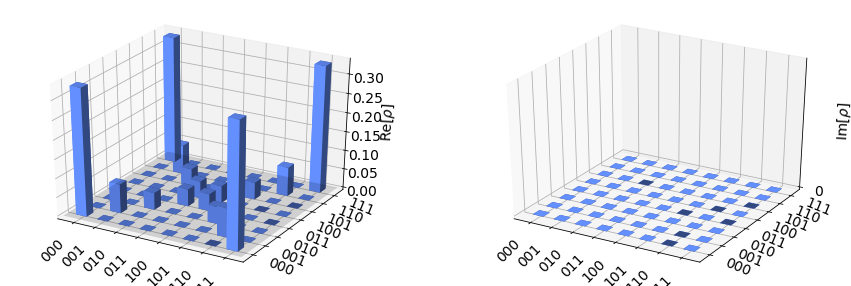

In [49]:
rho = qi.DensityMatrix.from_instruction(circ_noise)
plot_state_city(rho.data)

### Using Qiskit Aer noise tools

* There are a lot of useful tools for constructing quantum channels and noise models for simulation in the Qiskit Aer [noise module](https://qiskit.org/documentation/apidoc/aer_noise.html)

* These can be used with `QuantumCircuits` and the operator classes as well!

In [50]:
from qiskit.providers.aer import noise
error1 = noise.amplitude_damping_error(0.1)

qi.Kraus(error1)

Kraus([[[1.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.9486833 +0.j]],

       [[0.        +0.j, 0.31622777+0.j],
        [0.        +0.j, 0.        +0.j]]],
      input_dims=(2,), output_dims=(2,))

# Simulating Measurements and Probabilities

We can also use the `Statevector` and `DensityMatrix` classes to compute measurement probabilities and simulate measurement outcomes.

* This uses the [sample_counts](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.sample_counts.html) function

### Example: Ideal and noisy 5-qubit GHZ circuit

In [51]:
# Ideal circuit
circ = ghz_circuit(5)

# Noisy Circuit
noise_circ = ghz_circuit_noise(5, chan1, chan2)

### Ideal circuit measurements

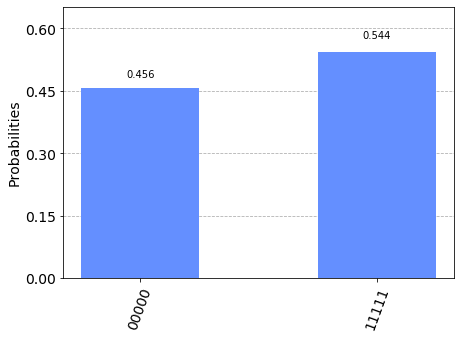

In [52]:
from qiskit.visualization import plot_histogram

psi = qi.Statevector.from_instruction(circ)

counts = psi.sample_counts(1000)
plot_histogram(counts)

### Noisy circuit measurements

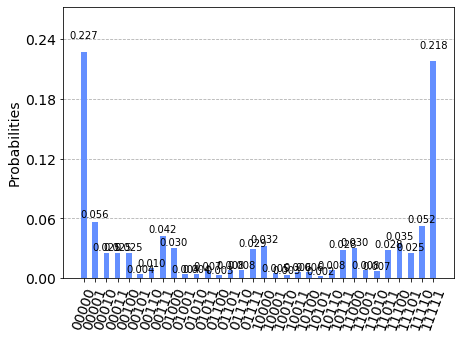

In [53]:
rho = qi.DensityMatrix.from_instruction(noise_circ)

noise_counts = rho.sample_counts(1000)
plot_histogram(noise_counts)

## Probabilities

If we want exact measurement *probabilites* instead of sampled counts we can use the [probabilities](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.probabilities.html) method.

* NOTE: both `sample_counts` and `probabilities` also work for marginal counts or probabilities on subsets of qubits

### Example: probabilities for qubits [0, 1]

Lets look at the probabilities for just measuring qubits 0 and 1 in the 5-qubit GHZ state

### Ideal circuit probabilities

In [54]:
psi.probabilities([0, 1])

array([0.5, 0. , 0. , 0.5])

### Noisy circuit probabilities

In [55]:
rho.probabilities([0, 1])

array([0.378, 0.122, 0.122, 0.378])

## So when do we use HPC simulators like Qiskit Aer?

* In most cases using these sort of simulators when you want the final statevector a unitary defeats the point
* Use them when you are simulating an *experiment* with *measurements*
  * Expensive simulation that requires a lot of memory for storing the state
  * Final data (ie. counts) requires very littly memory
  
 ![title](benchmarks/t_sim_counts.png)

![Circuit Simulation](figures/circuit_experiments.png)

## So when do we use HPC simulators like Qiskit Aer?

![title](benchmarks/t_sim_counts.png)

# Simulating circuits summary


* `Statevector`, `DensityMatrix`, `Clifford`, `Operator`, `SuperOp` all have different scaling
* Now that you're better informed you can use the right tool for the job!

| Class |  Allowed Circuit Types |Simulation Time | Simulation Memory |
| --- | --- | --- | --- |
| [Clifford](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Clifford.html) | Clifford circuits | $O(N)$ | $O(N^2)$ |
| [Statevector](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html) | Unitary circuits | $O(2^N)$ | $O(2^N)$ |
| [Operator](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) | Unitary circuits | $O(4^{N})$ | $O(4^{N})$ |
| [DensityMatrix](https://qiskit.org/documentation/stubs/qiskit.quantum_info.DensityMatrix.html) | Quantum channel (non-unitary) circuits | $O(4^{N})$ | $O(4^{N})$ |
| [SuperOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SuperOp.html) | Quantum channel (non-unitary) circuits |$O(16^{N})$ | $O(16^{N})$ |

![Circuit Simulation](benchmarks/t_sim.png)